# Interpetting and Evaluating Naive Bayes

We'll pikc up where we left off on Wedneday and we'll cover what the Naive
Bayes model assumes and some more evaluation.  Next week, we'll see a bit more
about it's predictions and see a new classifier.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
iris_df = sns.load_dataset('iris')

Again we'll load the data and split it to test and train and indicate which
variables to use as feature and the target.

In [2]:
feature_vars = ['sepal_length', 'sepal_width','petal_length', 'petal_width',]
target_var = 'species'
X_train, X_test, y_train, y_test = train_test_split(iris_df[feature_vars],
                                                   iris_df[target_var],
                                           test_size=.5, random_state=0)


This time we also made the test size larger (50% instead of default 25%)

## What does Naive Bayes do?

[docs](https://scikit-learn.org/stable/modules/naive_bayes.html)

Gaussian = features distributed according to the Gaussian Distribution (normal curve)
Naive = indepdent features
Bayes = most probable

[Bayes Estimator](https://en.wikipedia.org/wiki/Bayes_estimator)


To see, first we'll fit the model, hten examine it's strucutre.

In [3]:
gnb= GaussianNB()
gnb.fit(X_train,y_train)

gnb.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'feature_names_in_': array(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
       dtype=object),
 'n_features_in_': 4,
 'classes_': array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 'epsilon_': 3.6399039999999994e-09,
 'theta_': array([[4.97586207, 3.35862069, 1.44827586, 0.23448276],
        [5.935     , 2.71      , 4.185     , 1.3       ],
        [6.77692308, 3.09230769, 5.73461538, 2.10769231]]),
 'var_': array([[0.10321047, 0.13208086, 0.01629013, 0.00846612],
        [0.256275  , 0.0829    , 0.255275  , 0.046     ],
        [0.38869823, 0.10147929, 0.31303255, 0.04763314]]),
 'class_count_': array([29., 20., 26.]),
 'class_prior_': array([0.38666667, 0.26666667, 0.34666667])}

````{margin}
```{admonition} Further Reading
_All of this is beyond the scope of this course, but may be of interest_
The Scikit Learn [User Guide](https://scikit-learn.org/stable/user_guide.html) is
actually a really good place to learn the details of machine learning.  It is
high quality documentation from both a stattistical and computer science
perspective of every element of the library.

The sklearn [API](https://scikit-learn.org/stable/modules/classes.html) describes
how the library is structured and organized. Because the library is so popular
(and it's pretty well architected from a software perspective as well) if you
are developing new machine learnign techniques it's good to make them sklearn
compatible.  

For example, IBM's [AIF360](https://aif360.readthedocs.io/en/latest/index.html) is a package for doing fair machine learnign which has a
[sklearn compatible interface(https://aif360.readthedocs.io/en/latest/modules/sklearn.html). Scikit Learn documentation also includes a
[related projects](https://scikit-learn.org/stable/related_projects.html) page.
```

```{tip}
If you're interested in fair machine learning, let me know, this is what my research is
```
````

The attributes of the [estimator object](https://scikit-learn.org/stable/glossary.html#term-estimators) (`gbn`) describe the data (eg the class list) and the model's parameters. The `theta_` ($\theta$)
represents the mean and the `sigma_` ($\sigma$) represents the variance of the
distributions.  

```{admonition} Try it Yourself
Could you use what we learned about EDA to find the mean and variance of each
feature for each species of flower?
```

When we look at the data with a pair plot we see the distriution.  This data is
not perfectly Gaussian, but it's pretty close to unimodal (one peak) for each
feature and they're relatively [normal curve](https://en.wikipedia.org/wiki/Normal_distribution) like (as opposed to a vary sharp
  spike like a [laplacian](https://en.wikipedia.org/wiki/Laplace_distribution) )

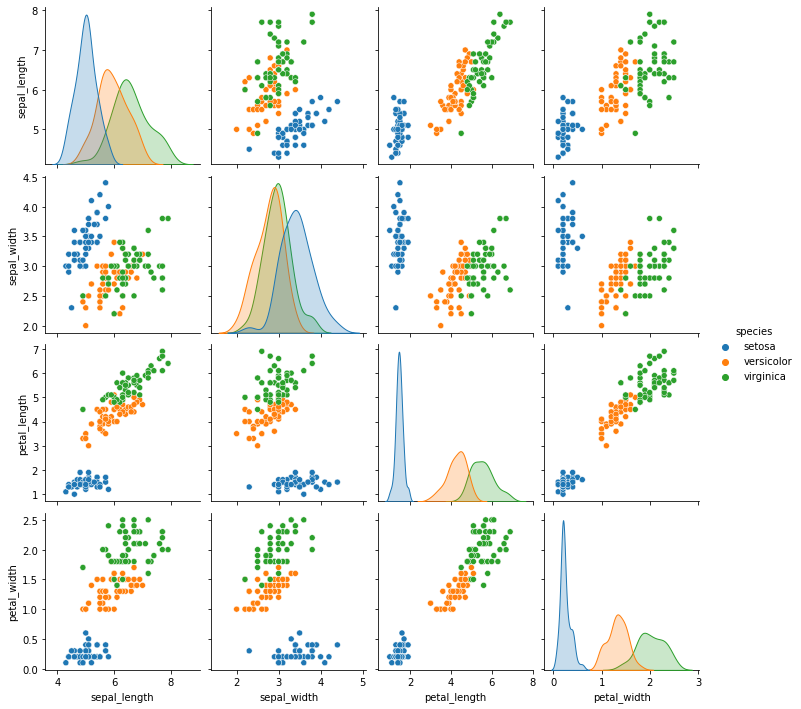

In [4]:
sns.pairplot(data=iris_df, hue='species')

Because the GaussianNB classifier calculates parameters that describe the
assumed distribuiton of the data is is called a generative classifier.  From a
generative classifer, we can generate synthetic data that is from the
distribution the classifer learned. If this data looks like our real data, then
the model assumptions fit well.

```{warning}
the details of this math are not required understanding, but this describes the
following block of code

```
````{margin}
```{hint}
to try understanding this block of code, try extracting pieces of it and running
each piece individually. I built it up piece by piece adn then wrapped them all
together.
```
````
To do this, we extract the mean and variance parameters from the model
(`gnb.theta_,gnb.sigma_`) and `zip` them together to create an iterable object
that in each iteration returns one value from each list (`for th, sig in zip(gnb.theta_,gnb.sigma_)`).
We do this inside of a list comprehension and for each `th,sig` where `th` is
from `gnb.theta_` and `sig` is from `gnb.sigma_` we use `np.random.multivariate_normal`
to get 20 samples. In a general [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) the second parameter is actually a covariance
matrix.  This describes both the variance of each individual feature and the
correlation of the features.  Since Naive Bayes is Naive it assumes the features
are independent or have 0 correlation.  So, to create the matrix from the vector
of variances we multiply by `np.eye(4)` which is the identity matrix or a matrix
with 1 on the diagonal and 0 elsewhere. Finally we stack the groups for each
species together with `np.concatenate` (like `pd.concat` but works on numpy objects
  and `np.random.multivariate_normal` returns numpy arrays not data frames) and put all of that in a
DataFrame using the feature names as the columns.

Then we add a species column, by repeating each species 20 times
`[c]*N for c in gnb.classes_` and then unpack that into a single list instead of
as list of lists.

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


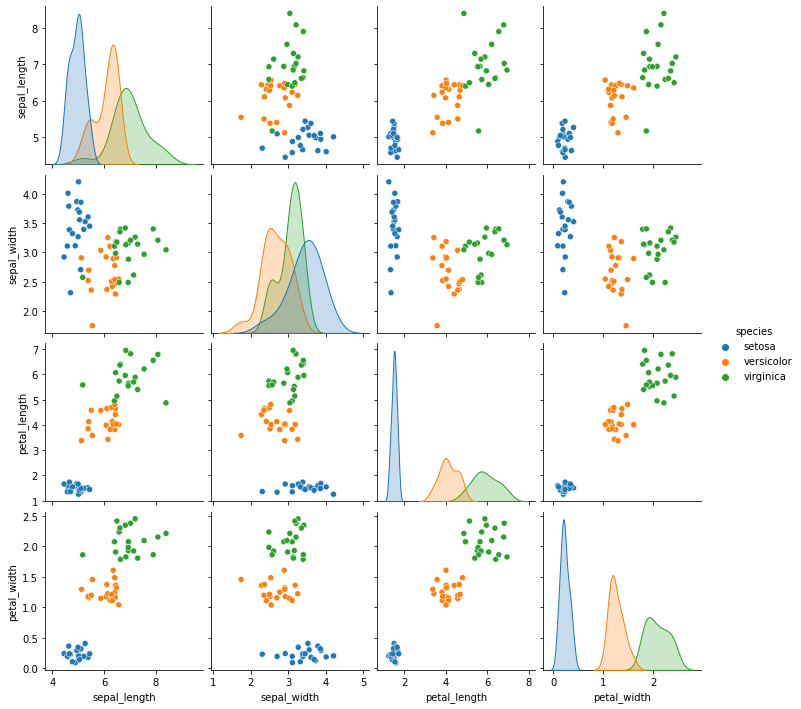

In [5]:
N = 20
gnb_df = pd.DataFrame(np.concatenate([np.random.multivariate_normal(th, sig*np.eye(4),N)
                 for th, sig in zip(gnb.theta_,gnb.sigma_)]),
                 columns = gnb.feature_names_in_)
gnb_df['species'] = [ci for cl in [[c]*N for c in gnb.classes_] for ci in cl]
sns.pairplot(data =gnb_df, hue='species')

````{margin}
```{admonition} Further Reading
There are other classifiers that use roughly the same model but don't make the
naive assumption. The more flexible is called Quadratic Discriminant Analysis.
- [mathematical formulation](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda-math) for both
- [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) code
- [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) code
```
````

This one looks pretty close to the actual data.  The biggest difference is that
these data are all in uniformly circular-ish blobs and the ones above are not.  
That means that the naive assumption doesn't hold perfectly on this data.  

## Evaluating

On Wedneday, we used predict and checked the results

In [6]:
y_pred = gnb.predict(X_test)

y_pred

array(['virginica', 'versicolor', 'setosa', 'virginica', 'setosa',
       'virginica', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'setosa', 'versicolor', 'versicolor', 'setosa',
       'setosa', 'virginica', 'versicolor', 'setosa', 'setosa',
       'virginica', 'setosa', 'setosa', 'versicolor', 'versicolor',
       'setosa', 'virginica', 'versicolor', 'setosa', 'virginica',
       'virginica', 'versicolor', 'setosa', 'versicolor', 'versicolor',
       'versicolor', 'virginica', 'setosa', 'virginica', 'setosa',
       'setosa', 'versicolor', 'virginica', 'virginica', 'versicolor',
       'virginica', 'versicolor', 'virginica', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'versicolor',
       'virginica', 'versicolor', 'setosa', 'virginica', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'virginica', 'setosa',
       'setosa', 'virginica

Then compared to see how many matched the ground truth.

In [7]:
sum(y_pred == y_test)

71

out of the total number
````{margin}
```{tip}
Note, we used the same random seed, but with a different test set size and got
a different reuslt because we have a different number of samples.
```
````

In [8]:
len(y_test)

75

Scikit Learn also provides a `score` method for all of the estimator object
(different models).  For a classifier, it provides the accuracy (percent correct).

In [9]:
gnb.score(X_test,y_test)

0.9466666666666667

which we could calculate with:

In [10]:
sum(y_pred == y_test)/len(y_test)

0.9466666666666667

The [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) counts the number for each class (in this case the species)
that truly have that value adn that were predicted to have that value.
The wikipedia article on [confusion matrices](https://en.wikipedia.org/wiki/Confusion_matrix) also summarized all of the different
metrics. Its written in terms of two, outcomes, but we have 3.

In [11]:
confusion_matrix(y_test, y_pred,labels = gnb.classes_)

array([[21,  0,  0],
       [ 0, 30,  0],
       [ 0,  4, 20]])

```{admonition} Try it yourself
Could you create a Data Frame with columns for predicted and true class, then
get the count of how many samples were in each combination? Does it match the table.
```


We can also get a report with a few metrics.

- Recall is the percent of each species that were predicted correctly.
- Precision is the percent of the ones predicted to be in a species that are truly that species.
- the F1 score is combination of the two

In [12]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        21
  versicolor       0.88      1.00      0.94        30
   virginica       1.00      0.83      0.91        24

    accuracy                           0.95        75
   macro avg       0.96      0.94      0.95        75
weighted avg       0.95      0.95      0.95        75



## Questions



```{admonition} Ram token Opportunity
Contribute a question as an issue or contribute a soultion to one of the try it yourself above.
```